**文本聚类和主题建模**

In [1]:
import pandas as pd

In [4]:
excel_df = pd.read_csv("r_data/arxiv_nlp/arxiv_nlp_data.csv", encoding="utf-8", low_memory=False, on_bad_lines="skip")
excel_df.to_parquet("r_data/arxiv_nlp/arxiv_nlp_data.parquet", engine="pyarrow")

In [ ]:
# excel_df = pd.read_parquet("r_data/arxiv_nlp_data.parquet")

In [2]:
from datasets import Dataset, DatasetDict

In [3]:
dataset_all = Dataset.from_parquet("r_data/arxiv_nlp/arxiv_nlp_data.parquet")

In [4]:
dataset = dataset_all.select(range(100))

In [5]:
dataset.shape

(100, 4)

In [6]:
# 提取元数据
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

文本聚类的通用流程： 嵌入模型（embedding model）-> 降维模型（dimensionality reduction model） -> 聚类模型（cluster model）

## 文本聚类

### 嵌入文档

In [7]:
from sentence_transformers import SentenceTransformer
# 为每个摘要创建嵌入向量
embedding_model = SentenceTransformer("/data/models/thenlper-gte-small")

In [ ]:
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

In [12]:
embeddings.shape

(100, 384)

In [9]:
import pickle

In [14]:
with open('r_data/arxiv_nlp/arxiv_nlp_origin_embedding_100.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [10]:
with open('r_data/arxiv_nlp/arxiv_nlp_origin_embedding_100.pkl', 'rb') as f:
    embeddings = pickle.load(f)

### 嵌入向量降维

In [11]:
# pip install umap-learn
from umap import UMAP
# 将输入嵌入向量从384维降至5维
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric="cosine", random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

C:\Users\ThinkPad\anaconda3\envs\peft\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [13]:
with open('r_data/arxiv_nlp/arxiv_nlp_reduced_embeddings.pkl', 'wb') as f:
    pickle.dump(reduced_embeddings, f)

In [14]:
# pip install hdbscan
from hdbscan import HDBSCAN

In [16]:
# 拟合模型并提取簇
hdbscan_model = HDBSCAN(
    min_cluster_size=5, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_
len(set(clusters))

C:\Users\ThinkPad\anaconda3\envs\peft\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ThinkPad\anaconda3\envs\peft\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


6

### 检查生成的簇

In [18]:
import numpy as np
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  We test a segmentation algorithm, based on the calculation of the
Jensen-Shannon divergence between probability distributions, to two symbolic
sequences of literary and musical origin. The first sequence represents the
successive appearance of characters in a theatrical play, and the second
repres... 

  We examine an evolutionary naming-game model where communicating agents are
equipped with an evolutionarily selected learning ability. Such a coupling of
biological and linguistic ingredients results in an abrupt transition: upon a
small change of a model control parameter a poorly communicating g... 

  Zipf's law states that if words of language are ranked in the order of
decreasing frequency in texts, the frequency of a word is inversely
proportional to its rank. It is very robust as an experimental observation, but
to date it escaped satisfactory theoretical explanation. We suggest that Zipf's... 



In [19]:
# 将文档嵌入降至二维，绘制文档
import pandas as pd
# 将384维的向量降至二维以便于可视化
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)
# 创建数据框
df = pd.DataFrame(reduced_embeddings, columns=["x","y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]
# 选择离群点和非离群点（聚类）
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

C:\Users\ThinkPad\anaconda3\envs\peft\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(5.171938347816467, 9.308269572257995, 1.2656815588474273, 6.010388678312301)

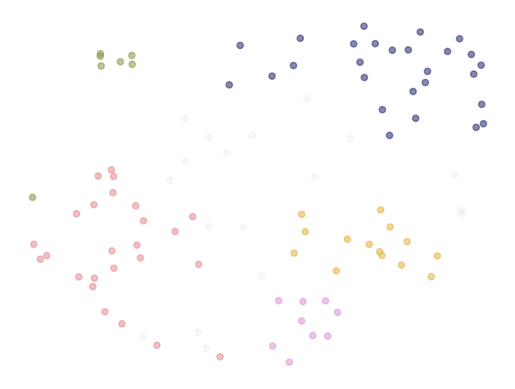

In [23]:
import matplotlib.pyplot as plt
# 分别绘制离群点和非离群点
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=20, c="grey")
plt.scatter(clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int), alpha=0.6, s=20, cmap="tab20b")
plt.axis("off")

## 主体建模

In [50]:
# pip install bertopic
# pip install bertopic[visualization]
from bertopic import BERTopic

In [51]:
# 使用之前定义的模型训练我们的模型
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-07-23 09:20:34,917 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-23 09:20:35,176 - BERTopic - Dimensionality - Completed ✓
2025-07-23 09:20:35,177 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-23 09:20:35,182 - BERTopic - Cluster - Completed ✓
2025-07-23 09:20:35,185 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-23 09:20:35,221 - BERTopic - Representation - Completed ✓


In [52]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,18,-1_the_of_to_and,"[the, of, to, and, in, is, as, language, for, ...",[ This paper discusses two new procedures for...
1,0,27,0_the_of_and_in,"[the, of, and, in, to, is, that, language, we,...",[ Background: Zipf's discovery that word freq...
2,1,25,1_of_the_and_in,"[of, the, and, in, to, for, we, with, grammar,...",[ Shifting to a lexicalized grammar reduces t...
3,2,14,2_the_of_to_semantic,"[the, of, to, semantic, in, and, on, is, are, ...",[ The goal of this paper is to present a mode...
4,3,9,3_the_of_we_in,"[the, of, we, in, and, to, events, for, is, this]",[ In this paper we present the first step in ...
5,4,7,4_the_native_recognition_non,"[the, native, recognition, non, speech, of, we...","[ In this paper, we present several adaptatio..."


In [53]:
topic_model.get_topic(0)

[('the', 0.0876200464985125),
 ('of', 0.08621575161342712),
 ('and', 0.05688542814779539),
 ('in', 0.04881712105605479),
 ('to', 0.040494773867762256),
 ('is', 0.03903876768513057),
 ('that', 0.0377718240288504),
 ('language', 0.03269613834881391),
 ('we', 0.02989083333350332),
 ('for', 0.02947134161630801)]

In [54]:
topic_model.find_topics("semantic")

([2, 1, -1, 3, 0], [0.90356064, 0.89592403, 0.8944212, 0.88370293, 0.87715065])

In [55]:
topic_model.get_topic(2)

[('the', 0.0729665375513771),
 ('of', 0.07112657700396774),
 ('to', 0.06387811972069568),
 ('semantic', 0.056954390393186304),
 ('in', 0.04812883252264661),
 ('and', 0.04770637044129778),
 ('on', 0.03676416550515996),
 ('is', 0.03580311381349086),
 ('are', 0.035093067073107234),
 ('words', 0.03414110188183097)]

In [56]:
topic_model.topics_[titles.index("A semantic space for modeling children's semantic memory")]

2

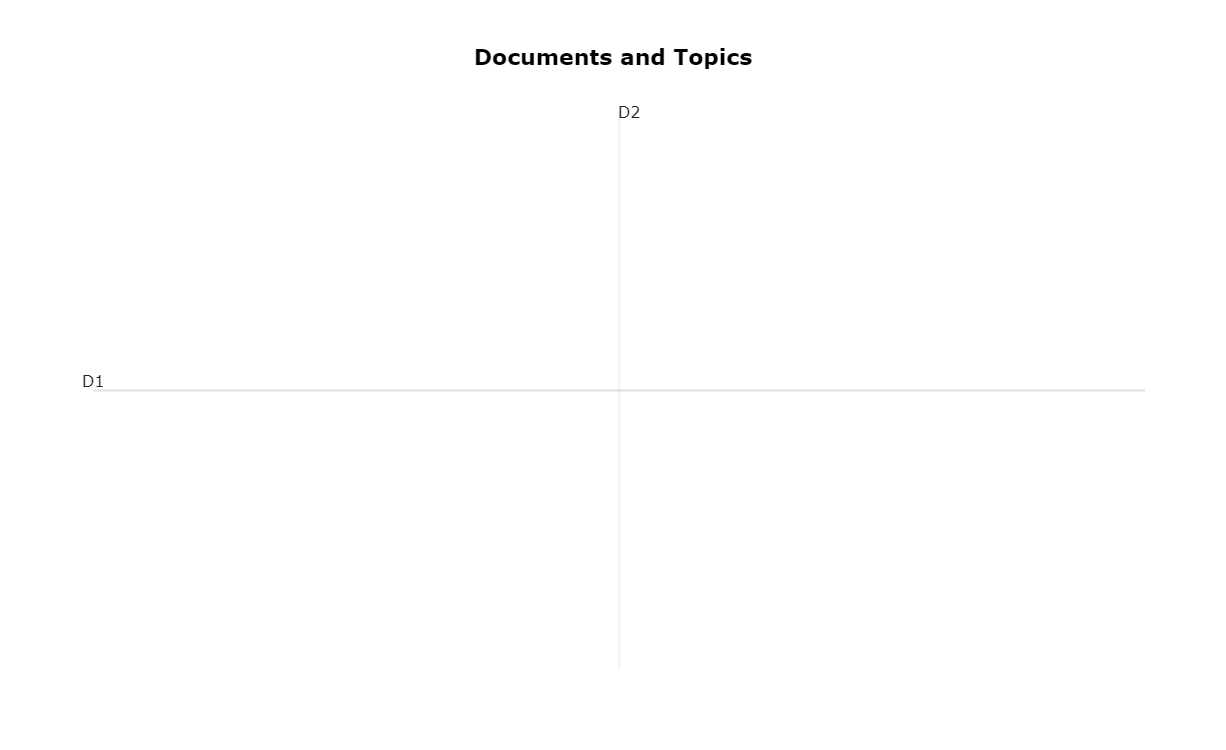

In [57]:
# 可视化主题和文档
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)
# 更新图例字体设置以便于可视化
fig.update_layout(font=dict(size=16))

### 添加特殊的“乐高积木块”

In [58]:
# 保存原始表示
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [63]:
def topic_differences(model, original_topics, nr_topics=5):
    """显示两个模型之间主题表示的差异"""
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):
        # 每个模型、每个主题提取前5个词
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]
    return df

In [64]:
from bertopic.representation import KeyBERTInspired
# 使用KeyBERTInspired更新主题表示
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)
# 展示主题差异
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,the | of | and | in | to,linguistic | words | language | word | statist...
1,1,of | the | and | in | to,parsing | parsers | grammar | syntactic | parser
2,2,the | of | to | semantic | in,semantic | lexical | vocabulary | words | disa...
3,3,the | of | we | in | and,summarizing | summarization | collocation | co...
4,4,the | native | recognition | non | speech,pronunciation | pronunciations | arabic | voic...


In [65]:
# 最大边际相关性（maximal marginal relevance，MMR）
from bertopic.representation import MaximalMarginalRelevance
# 将主题表示更新为最大边际相关性
representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts, representation_model=representation_model)
# 展示主题差异
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,the | of | and | in | to,of | to | language | texts | on
1,1,of | the | and | in | to,grammar | parser | tree | lexicon | language
2,2,the | of | to | semantic | in,to | semantic | on | words | contexts
3,3,the | of | we | in | and,the | is | evolving | automatic | fuzzy
4,4,the | native | recognition | non | speech,native | speech | models | error | arabic


In [66]:
from transformers import pipeline
from bertopic.representation import TextGeneration

In [67]:
prompt = """I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the documents and keywords, what is this topic about?"""

# 使用FLAN-T5更新主题表示
generator = pipeline("text2text-generation", model="D:/models/google-flan-t5-small")
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)
# 展示主题差异
topic_differences(topic_model, original_topics)

Device set to use cpu
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.17s/it]


,Topic,Original,Updated
0,0,the | of | and | in | to,Science/Tech | | | |
1,1,of | the | and | in | to,Syntactic parsing | | | |
2,2,the | of | to | semantic | in,lexico-semantic resources for children's seman...
3,3,the | of | we | in | and,Science/Tech | | | |
4,4,the | native | recognition | non | speech,Speech recognition | | | |


In [ ]:
from bertopic.representation import OpenAI
import openai
prompt = """I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]
Based on the information above, extract a short topic label in the following format: topic: <short topic label>"""
client = openai.OpenAI(api_key="sk", base_url="https://dashscope.aliyuncs.com/compatible-mode/v1")
representation_model = OpenAI(client, model="qwen-plus", exponential_backoff=True, chat=True, prompt=prompt, base_url="https://dashscope.aliyuncs.com/compatible-mode/v1")
topic_model.update_topics(abstracts, representation_model=representation_model)
# 展示主题差异
topic_differences(topic_model, original_topics)

In [ ]:
# pip install datamapplot
# 可视化主题和文档
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200
)